# Phase 1: Data Ingestion and Relational Mapping
## Project: Explainable Review Intelligence System

**Objective:** The goal of this stage is to ingest large-scale unstructured review data and map it to business metadata. This creates the foundation for high-dimensional feature engineering by linking customer sentiment to specific business attributes.

**Data Sources:**
* `yelp_academic_dataset_review.json`: Customer ratings and text.
* `yelp_academic_dataset_business.json`: Business categories and attributes.

**Note:** If you are someone reviewing this project, or want to run it on your own device,  make sure to download the <a href='https://business.yelp.com/data/resources/open-dataset/'>yelp open dataset</a>. After that, make sure that you create a `.env` file in which you will set the `BUSINESS_DATASET_PATH` and `REVIEW_DATASET_PATH` which will be the path to the json files.

---

## Project Goal & Engineering Philosophy

This notebook focuses on **data ingestion and structural normalization**, not modeling.

The objective at this stage is to:
- Preserve all available business information
- Convert semi-structured data into a stable tabular schema
- Avoid premature feature selection or dimensionality reduction

Feature expansion and filtering decisions are intentionally deferred to later phases,
where they will be guided by coverage, interpretability, and business relevance.


---

## Understanding the Dataset
### Business.json:
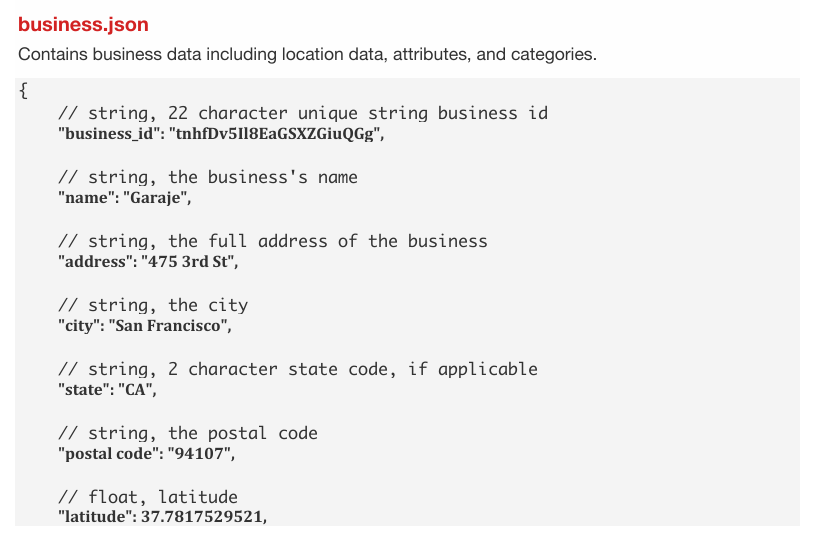
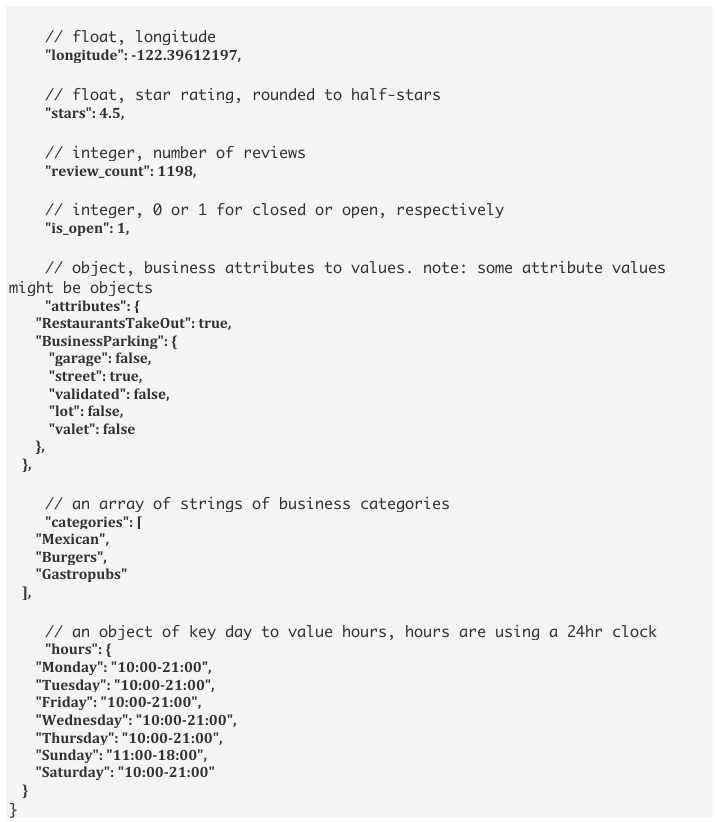

### Review.json:
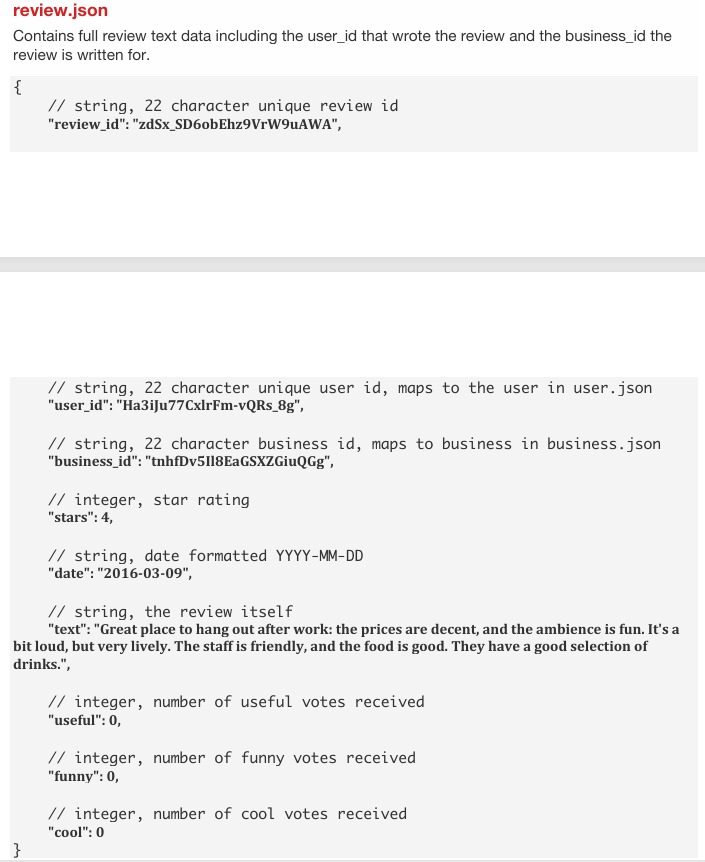

----

## 1. Importing Libraries

We will import the libraries here

In [2]:
import pandas as pd
import numpy as np
import ast

----

## 2. Memory-Efficient Data Loading
To maintain system stability while handling multi-gigabyte files, we are implementing a **chunked loading strategy**. 

* **Strategy:** Sample 100,000 records from the `review` dataset.
* **Logic:** This provides a statistically significant sample size for behavior analysis while staying within RAM limits.

In [28]:
import os
from dotenv import load_dotenv
import pandas as pd
from src.pipeline import build_business_table, build_review_table

# Load environment variables from .env file
load_dotenv()

# Access the dataset path using os.getenv()
# Provide a default value if the variable might be missing
business_data_path = os.getenv("BUSINESS_DATASET_PATH")
review_data_path = os.getenv("REVIEW_DATASET_PATH")    
# Use the path to load your dataset (e.g., using pandas)
try:
    business_df = build_business_table(business_data_path)
    review_df = build_review_table(review_data_path, sample=100000)  # Load only first 100,000 rows for reviews
    print(f"Successfully loaded dataset from: {business_data_path}")
    print(f"Successfully loaded dataset from: {review_data_path}")
except FileNotFoundError:
    print(f"Error: The file '{business_data_path}' or '{review_data_path}' was not found.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")


INFO:root:Loading data from C:/Users/HP/Desktop/Datasets/Yelp JSON/yelp_academic_dataset_business.json
INFO:root:Loaded 150346 records from C:/Users/HP/Desktop/Datasets/Yelp JSON/yelp_academic_dataset_business.json
INFO:root:Loading data from C:/Users/HP/Desktop/Datasets/Yelp JSON/yelp_academic_dataset_review.json
INFO:root:Loaded 6990280 records from C:/Users/HP/Desktop/Datasets/Yelp JSON/yelp_academic_dataset_review.json


Successfully loaded dataset from: C:/Users/HP/Desktop/Datasets/Yelp JSON/yelp_academic_dataset_business.json
Successfully loaded dataset from: C:/Users/HP/Desktop/Datasets/Yelp JSON/yelp_academic_dataset_review.json


In [29]:
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
1295256,J5Q1gH4ACCj6CtQG7Yom7g,56gL9KEJNHiSDUoyjk2o3Q,8yR12PNSMo6FBYx1u5KPlw,2.0,1,0,0,Went for lunch and found that my burger was me...,2018-04-04 21:09:53
3297618,HlXP79ecTquSVXmjM10QxQ,bAt9OUFX9ZRgGLCXG22UmA,pBNucviUkNsiqhJv5IFpjg,5.0,0,0,0,I needed a new tires for my wife's car. They h...,2020-05-24 12:22:14
1217795,JBBULrjyGx6vHto2osk_CQ,NRHPcLq2vGWqgqwVugSgnQ,8sf9kv6O4GgEb0j1o22N1g,5.0,0,0,0,Jim Woltman who works at Goleta Honda is 5 sta...,2019-02-14 03:47:48
3730348,U9-43s8YUl6GWBFCpxUGEw,PAxc0qpqt5c2kA0rjDFFAg,XwepyB7KjJ-XGJf0vKc6Vg,4.0,0,0,0,Been here a few times to get some shrimp. The...,2013-04-27 01:55:49
1826590,8T8EGa_4Cj12M6w8vRgUsQ,BqPR1Dp5Rb_QYs9_fz9RiA,prm5wvpp0OHJBlrvTj9uOg,5.0,0,0,0,This is one fantastic place to eat whether you...,2019-05-15 18:29:25


In [30]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,attributes_HairSpecializesIn_kids,attributes_HairSpecializesIn_perms,attributes_HairSpecializesIn_asian,attributes_DietaryRestrictions_dairy-free,attributes_DietaryRestrictions_gluten-free,attributes_DietaryRestrictions_vegan,attributes_DietaryRestrictions_kosher,attributes_DietaryRestrictions_halal,attributes_DietaryRestrictions_soy-free,attributes_DietaryRestrictions_vegetarian
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 100 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   business_id                                   150346 non-null  string 
 1   name                                          150346 non-null  string 
 2   address                                       150346 non-null  object 
 3   city                                          150346 non-null  object 
 4   state                                         150346 non-null  object 
 5   postal_code                                   150346 non-null  object 
 6   latitude                                      150346 non-null  float64
 7   longitude                                     150346 non-null  float64
 8   stars                                         150346 non-null  float32
 9   review_count                                  1

In [32]:
business_df.columns[0:50]

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'categories', 'attributes_ByAppointmentOnly',
       'attributes_BusinessAcceptsCreditCards', 'attributes_BikeParking',
       'attributes_RestaurantsPriceRange2', 'attributes_CoatCheck',
       'attributes_RestaurantsTakeOut', 'attributes_RestaurantsDelivery',
       'attributes_Caters', 'attributes_WiFi',
       'attributes_WheelchairAccessible', 'attributes_HappyHour',
       'attributes_OutdoorSeating', 'attributes_HasTV',
       'attributes_RestaurantsReservations', 'attributes_DogsAllowed',
       'attributes_Alcohol', 'attributes_GoodForKids',
       'attributes_RestaurantsAttire', 'attributes_RestaurantsTableService',
       'attributes_RestaurantsGoodForGroups', 'attributes_DriveThru',
       'attributes_NoiseLevel', 'attributes_BusinessAcceptsBitcoin',
       'attributes_Smoking', 'attributes_GoodForDancing',
       'attributes_Ac

In [33]:
business_df.columns[51:]

Index(['attributes_BusinessParking_garage',
       'attributes_BusinessParking_street',
       'attributes_BusinessParking_validated',
       'attributes_BusinessParking_lot', 'attributes_BusinessParking_valet',
       'attributes_Ambience_romantic', 'attributes_Ambience_intimate',
       'attributes_Ambience_touristy', 'attributes_Ambience_hipster',
       'attributes_Ambience_divey', 'attributes_Ambience_classy',
       'attributes_Ambience_trendy', 'attributes_Ambience_upscale',
       'attributes_Ambience_casual', 'attributes_GoodForMeal_dessert',
       'attributes_GoodForMeal_latenight', 'attributes_GoodForMeal_lunch',
       'attributes_GoodForMeal_dinner', 'attributes_GoodForMeal_brunch',
       'attributes_GoodForMeal_breakfast', 'attributes_Music_dj',
       'attributes_Music_background_music', 'attributes_Music_no_music',
       'attributes_Music_jukebox', 'attributes_Music_live',
       'attributes_Music_video', 'attributes_Music_karaoke',
       'attributes_BestNights_mond

In [34]:
business_df.filter(like="attributes_BusinessParking").dtypes


attributes_BusinessParking_garage       object
attributes_BusinessParking_street       object
attributes_BusinessParking_validated    object
attributes_BusinessParking_lot          object
attributes_BusinessParking_valet        object
dtype: object

In [18]:
values = business_df['attributes_BusinessParking_garage'].unique()

In [19]:
print(type(values[0]), values[1], values[2], values[3])

<class 'float'> False None True


---

Let us automate the process of finding columns with JSON/Dictionary Data, as that will be more efficient

## 4. Relational Merging (Many-to-One)
We are performing an **Inner Join** between the sampled Reviews and the full Business dataset.

* **Key:** `business_id`
* **Purpose:** To enrich each review with context (Industry, Location, and Service Attributes). This allows us to move from "What is the star rating?" to "Which business attributes drive this rating?"

In [50]:
df = pd.merge(business_df, review_df, on='business_id', how='inner')
df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,goodForMeal_brunch,goodForMeal_breakfast,review_id,user_id,stars_y,useful,funny,cool,text,date
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,0,0,9vwYDBVI3ymdqcyJ5WW2Tg,e0imecnX_9MtLnS2rUZM-A,5,3,2,1,I've had acupuncture treatments with Abby over...,2012-05-02 18:07:38
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,...,0,0,-WXMS4p3D9NQsAPw4YPEyw,Jks_uMtTZHqP-84wSZ3COg,5,0,0,0,I have a po box there and ea. visit I am greet...,2014-09-15 14:37:42
2,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,...,0,0,z7TqAKXXArEB6LH6Nfr9BQ,trf3Qcz8qvCDKXiTgjUcEg,3,1,0,1,"Bottom Line: \nClean store, Quick Service, Go...",2011-08-01 03:45:56
3,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,...,0,0,8Di0vZGcRLVNCZ-AWKgshA,auE6cx-AMcv2fv4SW_gnzA,5,0,0,0,I went in to ship a package to my friend for h...,2018-03-06 03:17:02
4,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,...,0,0,IOmiYoBPtQsY_fh5uA4mXg,P-NTOAMFVSDFGkhcj4GaIQ,4,1,0,0,We are fans of Target. They seem to have a li...,2017-02-19 15:11:22


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 83 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   business_id                      100000 non-null  object        
 1   name                             100000 non-null  object        
 2   address                          100000 non-null  object        
 3   city                             100000 non-null  object        
 4   state                            100000 non-null  object        
 5   postal_code                      100000 non-null  object        
 6   latitude                         100000 non-null  float64       
 7   longitude                        100000 non-null  float64       
 8   stars_x                          100000 non-null  float64       
 9   review_count                     100000 non-null  int64         
 10  is_open                          100000 non-n

---

## Why Modeling Is Not Performed in This Notebook

This notebook intentionally stops after structural normalization and initial feature
engineering.

Separating ingestion, feature engineering, and modeling:
- Improves reproducibility
- Prevents leakage
- Makes design decisions auditable

Subsequent notebooks will focus on exploratory analysis, modeling, and explainability
using the engineered feature set produced here.
